#library

In [1]:
import os
import glob
import random
import tensorflow
import numpy as np
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
# from keras_visualizer import visualizer 
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations

In [2]:
import cv2

In [3]:
# This method makes a 1 channel image and makes it binary 
def cvt_one_channel(img):
  pass

def thresh(img):
  pass

#Part1.compactness

In [5]:
def compatness(thresh):
  cnts,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  cnt = cnts[0]
  area = cv2.contourArea(cnt)
  perimeter = cv2.arcLength(cnt, False)

  compactness_score = np.divide(4 * np.pi * area , np.square(perimeter))
  return compactness_score

Compactness :  0.2039151263432431


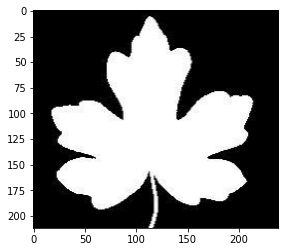

In [8]:
# Test compactness method
im = cv2.imread("/content/leaf.png")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret,otsu_thresh = cv2.threshold(gray,127,200,cv2.THRESH_BINARY)

plt.imshow(im)

print("Compactness : " , compatness(otsu_thresh))

#Part2.eccenticity

In [13]:
def eccenticity(image):

  cnts,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  cnt = cnts[0]

  ell = cv2.fitEllipse(cnt)
  centers , axes,orientation = ell

  cv2.ellipse(im ,ell,(0,255,0),2)


  eccentricity_score = axes[0] / axes[1]
  if eccentricity_score > 1 :
    eccentricity_score = 1 / eccentricity_score
  return eccentricity_score

In [14]:
# Test eccenticity method
im = cv2.imread("/content/leaf2.png")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray,127,200,cv2.THRESH_BINARY)

print("eccenticity : " , eccenticity(otsu_thresh))

eccenticity :  0.5502790397484624


#Part3.solidity

In [15]:
def solidity(thresh):

  cnts,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  cnt = cnts[0]

  area = cv2.contourArea(cnt)
  hull = cv2.convexHull(cnt)
  hull_area = cv2.contourArea(hull)
  if hull_area > 0 :
    solidity = float(area)/hull_area
  else :
    solidity = 0
  equi_diameter = np.sqrt(4*area/np.pi) # where to return this ??

  return  solidity


solidity :  0.7260873529679949


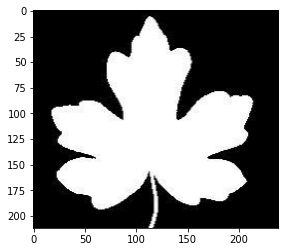

In [16]:
# Test solidity method
im = cv2.imread("/content/leaf.png")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret,otsu_thresh = cv2.threshold(gray,127,200,cv2.THRESH_BINARY)

plt.imshow(im)

print("solidity : " , solidity(otsu_thresh))

#Part4.LBP

In [17]:
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):
	lbp = feature.local_binary_pattern(image, numPoints,
			radius, method="uniform")
 
	(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, numPoints + 3),
			range=(0, numPoints + 2))
	# normalize the histogram
	hist = hist.astype("float")
	hist /= (hist.sum() + eps)
	return hist

In [20]:
# test lbp histogram
img = cv2.imread("/content/dataset/airplane/airplane185.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_,otsu_thresh = cv2.threshold(gray,127,200,cv2.THRESH_BINARY)

hist = histogram_of_LBP( otsu_thresh, 8 , 2 )

#validate function

In [21]:
OTSU_FIRST = 40
OTSU_SECOND = 200

def validating_func(image_ship_path, image_airplane_path):
  ship_img = cv2.imread(image_ship_path)
  airplane_img = cv2.imread(image_airplane_path)

  gray = cv2.cvtColor(ship_img, cv2.COLOR_BGR2GRAY)
  ret,ship_img = cv2.threshold(gray,OTSU_FIRST,OTSU_SECOND,cv2.THRESH_BINARY)

  gray = cv2.cvtColor(airplane_img, cv2.COLOR_BGR2GRAY)
  ret,airplane_img = cv2.threshold(gray,OTSU_FIRST,OTSU_SECOND,cv2.THRESH_BINARY)

  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

In [22]:
airplane_path = "/content/dataset/airplane/airplane141.jpg"
ship_path = "/content/dataset/ship/1244690.jpg"

validating_func(ship_path , airplane_path)

Result for ship image:
compatness is : 0.8361431729535662		eccenticity is : 0.5502790397484624		solidity is : 0.9925639228354616
Result for airplane image:
compatness is : 0.0		eccenticity is : 0.5502790397484624		solidity is : 0


#Part5.prepare dataset(just run this cell and not change)

In [ ]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

In [24]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(
      cv2.resize(
          cv2.cvtColor(
              cv2.imread(img_path) , cv2.COLOR_BGR2GRAY
          )
          , (224,224))
      )
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

In [25]:
 x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [26]:
def get_featureMatrix(data):

  feature_matrix = []
  y_train = []

  for im in data:
    row = []

    # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    _,thresh = cv2.threshold(gray,127,200,cv2.THRESH_BINARY)


    # compactness
    compactness_score = compatness(thresh)
    row.append(np.nan_to_num(compactness_score))


    # eccentricity
    eccentricity_score = eccenticity(thresh)
    row.append(np.nan_to_num(eccentricity_score))

    # solidity
    solidity_score = solidity(thresh)
    row.append(np.nan_to_num(solidity_score))

    # LBP
    lbp_hist = histogram_of_LBP( thresh, 8 , 1)
    # Concatanating
    row = np.concatenate((row , lbp_hist))

    feature_matrix.append(row)

  return feature_matrix


In [129]:
# model 1
feature_matrix_train = get_featureMatrix(x_train)
#determine classifier and train

lin_clf = svm.LinearSVC(multi_class='ovr', max_iter=1000)
lin_clf.fit(feature_matrix_train,y_train)

<ipython-input-21-dba7b7e8bb6b>:8: RuntimeWarning: invalid value encountered in true_divide
  compactness_score = np.divide(4 * np.pi * area , np.square(perimeter))


LinearSVC()

#Part7

In [130]:
#test on test dataset
prediction = lin_clf.predict(x_test)

accuracy_score(y_test , prediction)

ValueError: ignored

#Part8

<ipython-input-21-dba7b7e8bb6b>:8: RuntimeWarning: invalid value encountered in true_divide
  compactness_score = np.divide(4 * np.pi * area , np.square(perimeter))


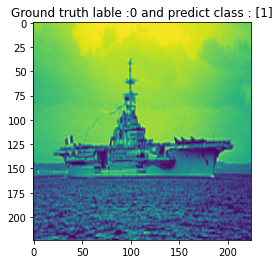

In [136]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = lin_clf.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()